# RANDRIANAMBININA Tokiniaina Jean Anicet Jonhia
Arbre de Décision

# Étude de cas — Rétention / Churn

**Objectif** : pipeline complet (données synthétiques → prétraitement → arbre de décision → évaluation → interprétation). Chaque section est une cellule exécutable. Le code est commenté de façon professionnelle pour un rendu étudiant / pro.

**Instructions** : exécute les cellules dans l'ordre. Les figures seront affichées et sauvegardées dans `outputs/`.


## 1) Imports et configuration

In [11]:
# Imports et configuration globale
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Pour reproductibilité
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Dossier de sortie pour figures / livrables
OUTDIR = 'outputs'
os.makedirs(OUTDIR, exist_ok=True)

print('Environnement prêt — outputs ->', OUTDIR)


Environnement prêt — outputs -> outputs


## 2) Génération du jeu synthétique
La fonction ci-dessous crée un jeu de données conforme à l'énoncé.

In [2]:
def generate_data(n=2500, random_state=RANDOM_STATE):
    """Génère un DataFrame synthétique pour le problème churn.
    Variables numériques : revenu, anciennete_mois, freq_usage, support_tickets
    Variables catégorielles : canal_acq, segment, region
    Cible : churn (0/1) simulée via un logit artificiel.
    """
    rng = np.random.default_rng(random_state)
    revenu = rng.normal(600, 180, n).clip(80, 1500)            # revenu (k MGA / mois)
    anciennete_mois = rng.integers(1, 72, n)                  # ancienneté en mois
    freq_usage = rng.normal(10, 4, n).clip(0, 50)             # interactions / mois
    support_tickets = rng.poisson(1.2, n)                     # tickets support / mois

    canal_acq = rng.choice(['Web', 'Magasin', 'Partenaire'], size=n, p=[0.55, 0.35, 0.10])
    segment = rng.choice(['B2C', 'B2B'], size=n, p=[0.8, 0.2])
    region = rng.choice(['Nord', 'Sud', 'Est', 'Ouest'], size=n, p=[0.27, 0.23, 0.25, 0.25])

    # logit synthétique — coefficients choisis pour illustrer effets
    z = (
        -2.2
        - 0.002 * (revenu - 600)
        - 0.01 * (anciennete_mois - 12)
        - 0.04 * (freq_usage - 8)
        + 0.18 * (support_tickets - 1)
        + 0.25 * (canal_acq == 'Web')
        - 0.15 * (canal_acq == 'Magasin')
        + 0.35 * (segment == 'B2C')
        + 0.10 * (region == 'Nord')
        - 0.05 * (region == 'Sud')
    )

    p = 1 / (1 + np.exp(-z))
    churn = rng.binomial(1, p)

    df = pd.DataFrame({
        'revenu': revenu,
        'anciennete_mois': anciennete_mois,
        'freq_usage': freq_usage,
        'support_tickets': support_tickets,
        'canal_acq': canal_acq,
        'segment': segment,
        'region': region,
        'churn': churn
    })
    return df

# Génération et affichage d'un extrait
df = generate_data(n=2500)
df.head()


,revenu,anciennete_mois,freq_usage,support_tickets,canal_acq,segment,region,churn
0,654.849074,71,11.123417,4,Web,B2C,Est,0
1,412.802861,2,10.184813,1,Web,B2C,Ouest,0
2,735.081215,17,12.785648,0,Web,B2C,Ouest,0
3,769.301649,19,13.740435,1,Magasin,B2C,Nord,0
4,248.813666,19,13.644912,0,Magasin,B2C,Nord,0


## 3) Split train / test
Stratification sur la cible pour conserver la distribution de churn.

In [3]:
# Séparation features / cible et train/test
X = df.drop(columns=['churn'])
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

print('Taille train:', X_train.shape, 'Taille test:', X_test.shape)
y_train.value_counts(normalize=True).round(3).to_frame('proportion_train')


Taille train: (1875, 7) Taille test: (625, 7)


,proportion_train
churn,
0,0.867
1,0.133


## 4) Prétraitements
Standardisation des variables numériques (utile pour comparaisons) et OneHot pour les catégorielles.

In [5]:
# Définition des colonnes
num_cols = ['revenu', 'anciennete_mois', 'freq_usage', 'support_tickets']
cat_cols = ['canal_acq', 'segment', 'region']

# ColumnTransformer propre et lisible
preprocess = ColumnTransformer(transformers=[
    ('num', StandardScaler(with_mean=True, with_std=True), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='drop')

# Pipeline complet avec DecisionTree (paramètres initiaux raisonnables)
def build_pipeline(random_state=RANDOM_STATE, max_depth=5, min_samples_leaf=30, criterion='gini'):
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    pipe = Pipeline(steps=[('prep', preprocess), ('model', clf)])
    return pipe

pipe = build_pipeline()
pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['revenu', 'anciennete_mois',
                                                   'freq_usage',
                                                   'support_tickets']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['canal_acq', 'segment',
                                                   'region'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=30,
                                        random_state=42))])

## 5) Entraînement et évaluation — pipeline de base
Calcul des métriques (Accuracy, ROC-AUC), matrice de confusion et courbe ROC.

Accuracy test : 0.867 | ROC-AUC : 0.543

Classification report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       542
           1       0.00      0.00      0.00        83

    accuracy                           0.87       625
   macro avg       0.43      0.50      0.46       625
weighted avg       0.75      0.87      0.81       625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


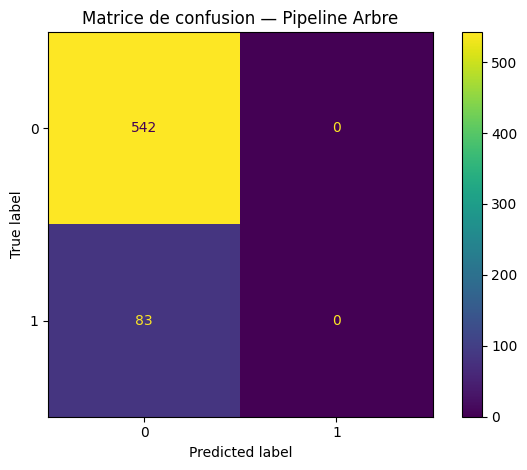

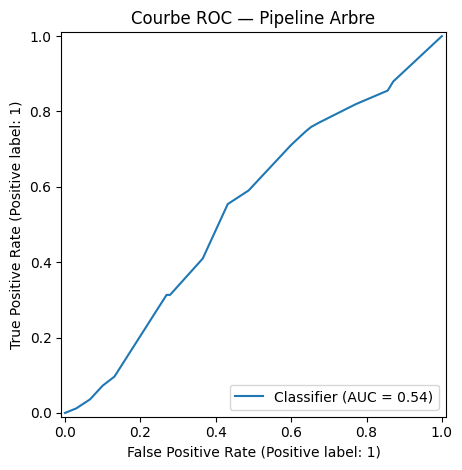

In [6]:
# Entraînement du pipeline
pipe.fit(X_train, y_train)

# Prédictions et probabilités
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Métriques principales
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy test : {acc:.3f} | ROC-AUC : {auc:.3f}\n')
print('Classification report:\n', classification_report(y_test, y_pred))

# Matrice de confusion (affichage + sauvegarde)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Matrice de confusion — Pipeline Arbre')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'confusion_matrix_base.png'), dpi=150)
plt.show()

# Courbe ROC (affichage + sauvegarde)
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('Courbe ROC — Pipeline Arbre')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'roc_curve_base.png'), dpi=150)
plt.show()


## 6) Validation croisée et GridSearch
Recherche des meilleurs hyperparamètres sur un espace restreint.

In [7]:
# AUC CV (5 folds) sur l'ensemble complet (rapide)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print('AUC CV (5 folds):', scores.mean().round(3), '+/-', scores.std().round(3))

# GridSearch — paramètre raisonnable pour démonstration
param_grid = {
    'model__max_depth': [3, 5, 7, 9],
    'model__min_samples_leaf': [10, 20, 30, 50],
    'model__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print('\nMeilleurs hyperparametres :', grid.best_params_)
print('Meilleure AUC CV (GridSearch) :', grid.best_score_.round(4))

best_pipe = grid.best_estimator_


AUC CV (5 folds): 0.588 +/- 0.013

Meilleurs hyperparametres : {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 10}
Meilleure AUC CV (GridSearch) : 0.6305


## 7) Évaluation du meilleur modèle sur le test set

AUC test (meilleur) : 0.5611

Classification report (meilleur):
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       542
           1       0.00      0.00      0.00        83

    accuracy                           0.87       625
   macro avg       0.43      0.50      0.46       625
weighted avg       0.75      0.87      0.81       625



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


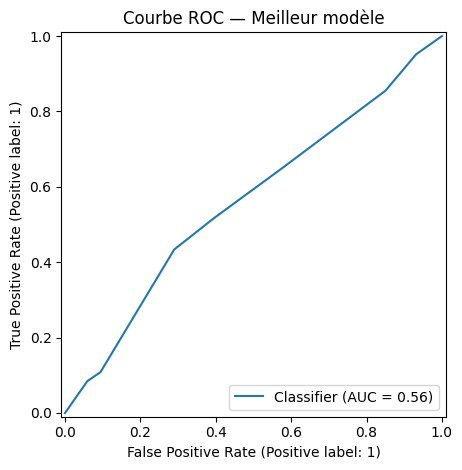

In [8]:
best_pred = best_pipe.predict(X_test)
best_proba = best_pipe.predict_proba(X_test)[:, 1]

print('AUC test (meilleur) :', roc_auc_score(y_test, best_proba).round(4))
print('\nClassification report (meilleur):\n', classification_report(y_test, best_pred))

# Sauvegarder courbe ROC du meilleur modèle
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title('Courbe ROC — Meilleur modèle')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'roc_curve_best.png'), dpi=150)
plt.show()


## 8) Interprétation — importances & règles lisibles
Refit d'un arbre sur les features transformées pour extraire importances et règles compréhensibles.

Top features:
              feature  importance
              revenu    0.484253
       canal_acq_Web    0.193403
     anciennete_mois    0.185651
        region_Ouest    0.136693
          freq_usage    0.000000
   canal_acq_Magasin    0.000000
     support_tickets    0.000000
         segment_B2B    0.000000
canal_acq_Partenaire    0.000000
         segment_B2C    0.000000
          region_Est    0.000000
         region_Nord    0.000000


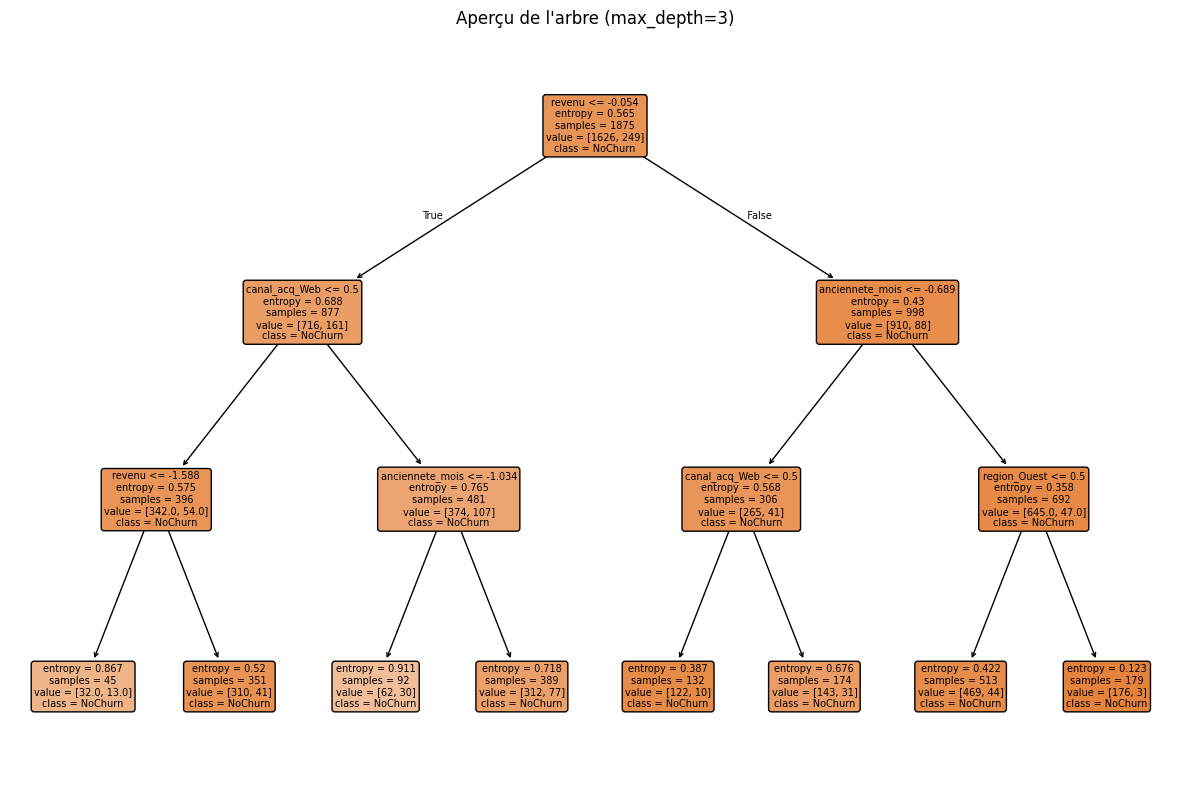


Règles extraites (max_depth=3):

|--- revenu <= -0.05
|   |--- canal_acq_Web <= 0.50
|   |   |--- revenu <= -1.59
|   |   |   |--- class: 0
|   |   |--- revenu >  -1.59
|   |   |   |--- class: 0
|   |--- canal_acq_Web >  0.50
|   |   |--- anciennete_mois <= -1.03
|   |   |   |--- class: 0
|   |   |--- anciennete_mois >  -1.03
|   |   |   |--- class: 0
|--- revenu >  -0.05
|   |--- anciennete_mois <= -0.69
|   |   |--- canal_acq_Web <= 0.50
|   |   |   |--- class: 0
|   |   |--- canal_acq_Web >  0.50
|   |   |   |--- class: 0
|   |--- anciennete_mois >  -0.69
|   |   |--- region_Ouest <= 0.50
|   |   |   |--- class: 0
|   |   |--- region_Ouest >  0.50
|   |   |   |--- class: 0



In [9]:
# Récupérer le preprocess et transformer X_train
prep = best_pipe.named_steps['prep']
Xt = prep.transform(X_train)

# Recréer un arbre avec les mêmes hyperparamètres (pour inspecter importances/règles)
model_params = best_pipe.named_steps['model'].get_params()
clf_best = DecisionTreeClassifier(**model_params)
clf_best.fit(Xt, y_train)

# Récupérer noms des features après OneHot
ohe = prep.named_transformers_['cat']
try:
    cat_names = ohe.get_feature_names_out(cat_cols)
except Exception:
    cat_names = ohe.get_feature_names(cat_cols)

feature_names = np.r_[num_cols, cat_names]

# Importances
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': clf_best.feature_importances_
}).sort_values('importance', ascending=False)

print('Top features:\n', importances.head(12).to_string(index=False))

# Aperçu de l'arbre (tronqué pour lisibilité)
plt.figure(figsize=(12, 8))
plot_tree(clf_best, feature_names=feature_names, class_names=['NoChurn', 'Churn'],
          filled=True, rounded=True, fontsize=7, max_depth=3)
plt.title('Aperçu de l\'arbre (max_depth=3)')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'tree_preview.png'), dpi=150)
plt.show()

# Règles lisibles (export_text)
rules = export_text(clf_best, feature_names=list(feature_names), max_depth=3)
print('\nRègles extraites (max_depth=3):\n')
print(rules)


## 9) Recommandations opérationnelles & livrables
- Prioriser clients faible usage (freq_usage faible) et tickets support élevés pour actions de rétention.
- Mettre en place une offre de bienvenue / fidélisation pour anciens clients récents (3-6 mois).

**Livrables produits par ce notebook :** figures PNG dans `outputs/`, tableau des importances, règles texte.


In [12]:
#sauvegarde des données et du pipeline
df.to_csv(os.path.join(OUTDIR, 'synthetic_churn_data.csv'), index=False)
print('Données synthétiques sauvegardées:', os.path.join(OUTDIR, 'synthetic_churn_data.csv'))

Données synthétiques sauvegardées: outputs/synthetic_churn_data.csv
